# Projecte part CNN


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the Runtime menu")
device = torch.device("cuda")

hparams = {
    'batch_size':100,
    'num_epochs':12,
    'val_batch_size':100,
    'num_classes':10,
    'learning_rate':1e-3,
    'log_interval':100,
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [69]:
# Functions to help us train the model
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()
        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.to(device)
            #target = target.unsqueeze(-1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            pred = output.round()  # get the prediction
            acc = 100 * (correct_predictions(output, target) / data.shape[0])
            train_accuracy.update(acc, n=len(target))
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()
        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.to(device)
                #target = target.unsqueeze(-1)
                output = model(data)
                loss = loss_fn(output, target)
                val_loss.update(loss.item(), n=len(target))
                pred = output.round()  # get the prediction
                acc = 100*(correct_predictions(output, target) / data.shape[0])
                val_accuracy.update(acc, n=len(target))
                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)
        
    return train_accuracies, train_losses, val_accuracies, val_losses

In [70]:
# import data from drive to local
import os, shutil
from google.colab import drive
drive.mount('/content/drive')

# import data for learning
og_dir = 'drive/MyDrive/'
train_dir = og_dir + 'data/training_set/'
test_dir  = og_dir + 'data/test_set/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Read and preprocess data
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.RandomResizedCrop(150), transforms.ToTensor()])
val_transform = transforms.Compose([transforms.Resize(150), transforms.CenterCrop(150), transforms.ToTensor()])
batch_size = 32

train_dataset = ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(test_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [72]:
# Define CNN
model = nn.Sequential(
        nn.Conv2d(3, 64, 3), nn.ReLU(inplace=True), nn.MaxPool2d(2), 
        nn.Conv2d(64, 128, 3), nn.ReLU(inplace=True), nn.MaxPool2d(2), 
        nn.Conv2d(128, 256, 3), nn.ReLU(inplace=True), nn.MaxPool2d(2), 
        nn.Conv2d(256, 256, 3), nn.ReLU(inplace=True), nn.MaxPool2d(2), 
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(7*7*256, 512), nn.ReLU(),
        nn.Linear(512, 10), 
        nn.LogSoftmax(dim=-1)
    )

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.nll_loss
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=12544, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=10, bias=True)
  (17): LogSoftmax(dim=-1)
)

In [75]:
# train the neural network
epochs = 30
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

  0%|          | 0/29 [00:00<?, ? batches/s]

  0%|          | 0/4 [00:00<?, ? batches/s]

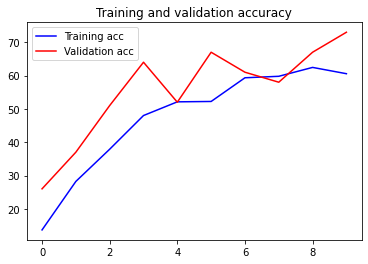

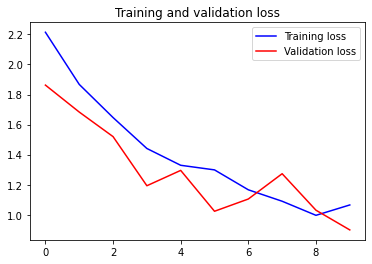

In [74]:
# check for possible overfititng
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()